In [90]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    confusion_matrix,
    roc_curve, auc,
    precision_recall_curve,
    precision_score, recall_score, f1_score,accuracy_score,
    classification_report,
    ConfusionMatrixDisplay
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_predict


def plot_confusion_matrices(cm_train, cm_test, title_prefix):
    """
    Plota duas matrizes de confusão lado a lado (treino e teste).
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Treino
    disp_train = ConfusionMatrixDisplay(cm_train)
    disp_train.plot(ax=axes[0], cmap="Blues", colorbar=False)
    axes[0].set_title(f'{title_prefix} - Treino')
    
    # Teste
    disp_test = ConfusionMatrixDisplay(cm_test)
    disp_test.plot(ax=axes[1], cmap="Blues", colorbar=False)
    axes[1].set_title(f'{title_prefix} - Teste')
    
    plt.tight_layout()
    plt.show()


def plot_roc_curve(fpr, tpr, roc_auc, threshold_point=None, threshold_value=None, model_name=''):
    """
    Plota a curva ROC.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random')
    
    if threshold_point is not None:
        plt.scatter(threshold_point[0], threshold_point[1], color='red', s=100, 
                   label=f'Limiar Otimizado ({threshold_value:.4f})', zorder=5)
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Curva ROC - {model_name}')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_precision_recall_curve(recall_vals, precision_vals, threshold_point=None, threshold_value=None, model_name=''):
    """
    Plota a curva Precision-Recall.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(recall_vals, precision_vals, color='green', lw=2, label='Precision-Recall curve')
    
    if threshold_point is not None:
        plt.scatter(threshold_point[0], threshold_point[1], color='red', s=100, 
                   label=f'Best F1 ({threshold_value:.4f})', zorder=5)
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Curva Precision-Recall - {model_name}')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def find_optimal_threshold(y_true, y_proba, thresholds,):
    """
    Encontra o limiar que maximiza o F1-Score.
    """
    f1_scores = []
    for thresh in thresholds:
        y_pred_thresh = (y_proba >= thresh).astype(int)
        f1_scores.append(f1_score(y_true, y_pred_thresh))
    
    best_threshold_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_threshold_idx]
    
    return best_threshold, best_threshold_idx, f1_scores


def plot_threshold_analysis(fpr, tpr, roc_auc, recall_vals, precision_vals, 
                           cm_threshold, threshold_point_roc, threshold_point_pr, 
                           threshold_value, model_name=''):
    """
    Plota análise completa do limiar: ROC, Precision-Recall e Matriz de Confusão.
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Curva ROC
    axes[0].plot(fpr, tpr, color='blue', lw=2, label=f'Curva Roc')
    axes[0].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random')
    axes[0].scatter(threshold_point_roc[0], threshold_point_roc[1], color='red', s=100, 
                   label=f'Limiar Otimizado', zorder=5)
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title(f'Curva ROC - {model_name}')
    axes[0].legend(loc='lower right')
    axes[0].grid(True, alpha=0.3)
    
    # Curva Precision-Recall
    axes[1].plot(recall_vals, precision_vals, color='green', lw=2, label='Precision-Recall curve')
    axes[1].scatter(threshold_point_pr[0], threshold_point_pr[1], 
                   color='red', s=100, label=f'F1', zorder=5)
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_title(f'Curva Precision-Recall - {model_name}')
    axes[1].legend(loc='best')
    axes[1].grid(True, alpha=0.3)
    
    # Matriz de confusão com limiar otimizado
    disp_threshold = ConfusionMatrixDisplay(cm_threshold)
    disp_threshold.plot(ax=axes[2], cmap='Blues', colorbar=False)
    axes[2].set_title(f'Matriz de Confusão - Limiar Otimizado\n(Limiar = {threshold_value:.4f})')
    
    plt.tight_layout()
    plt.show()



<h2 style="text-align: center;">Instituto Superior de Engenharia de Lisboa</h2>  
<h3 style="text-align: center;">Licenciatura em Engenharia Informática e Multimédia</h3>
<p  style="margin-top:20px;text-align: center;">Aprendizagem Automática</p>
<p  style="text-align: center;">Semestre de Inverno 2024/2025</p>
<p  style="text-align: center;">1º Trabalho Prático</p>
<p  style="text-align: center;">Trabalho realizado por: </p>
<div style="margin:auto; display:flex"> 
    <ul style="margin:auto; display:block">
        <li>Alice Fernandes, Aluna Nº 45741</li>
        <li>Guilherme Mendes, Aluno Nº  49718</li>
        <li>Bruno, Aluno Nº 49755</li>
    </ul>
</div>

# Indíce
1. [Indíce de Figuras](#1---Indíce-de-Figuras)
2. [Introdução](#2---Introdução)
3. [Desenvolvimento](#3---Desenvolvimento)
4. [Conclusão](#4---Conclusão)
5. [Bibliografia](#5---Bibliografia)

# 1 - Indíce de Figuras
1. [Figura 1 - _Workflow_ de uma aplicação que utilize processamento digital de visão](#fig10) 
2. [Figura 2 - Primeiros 2 segundos do vídeo de entrada](#fig1) 
3. [Figura 3 - Cálculo da imagem de fundo](#fig2) 
4. [Figura 4 - Subtração da fundo à frame](#fig3) 
5. [Figura 5 - Subtração da fundo à frame (escala de cinza)](#fig4) 
6. [Figura 6 - Binarização da imagem sem fundo](#fig5) 
7. [Figura 7 - Imagem após erosão](#fig6) 
8. [Figura 8 - Imagem após erosão e fecho](#fig7) 
9. [Figura 9 - Frame Inicial](#fig8) 
10. [Figura 10 - Frame Final](#fig9) 

# 2 - Introdução

A diabetes é uma doença crónica que afeta milhões de pessoas em todo o mundo, caracterizada por níveis elevados de glicose no sangue. O diagnóstico precoce e preciso desta condição é fundamental para prevenir complicações graves e melhorar a qualidade de vida dos pacientes.

Este trabalho utiliza o **Pima Indians Diabetes Dataset**, criado pelo National Institute of Diabetes and Digestive and Kidney Diseases (EUA), que contém informação sobre 768 mulheres da população indígena Pima, uma população com elevada incidência de diabetes. O dataset inclui 500 mulheres sem diabetes e 268 mulheres com diabetes, sendo cada observação caracterizada por 8 atributos clínicos relevantes: 
- número de gravidezes, 
- concentração de glicose plasmática, 
- pressão arterial diastólica, 
- espessura da dobra cutânea do tríceps, 
- nível sérico de insulina, 
- índice de massa corporal, 
- Diabetes Pedigree Function,
- Idade

O objetivo principal deste trabalho é desenvolver e comparar diferentes modelos de classificação binária capazes de determinar automaticamente se um paciente apresenta diabetes com base nas características fornecidas. Para tal, serão implementados e avaliados três classificadores, incluindo obrigatoriamente o Random Forest, utilizando metodologias adequadas de treino/teste e métricas apropriadas para avaliar o desempenho dos modelos.

Adicionalmente, será investigado o impacto da normalização dos dados no desempenho dos classificadores, analisando se a transformação dos dados para média nula e variância unitária contribui para melhorar a capacidade preditiva dos modelos.

O relatório apresenta uma análise dos resultados obtidos, justificando as escolhas realizadas e discutindo as decisões tomadas ao longo do desenvolvimento do trabalho.


# 3 - Desenvolvimento

Para este trabalho, foram selecionados três classificadores binários para a tarefa de classificação de diabetes. O **Random Forest Classifier** é um classificador obrigatório, baseado em ensemble de árvores de decisão. O **Support Vector Classifier (SVC)** é um algoritmo baseado em máquinas de vetores de suporte com diferentes kernels. A **Logistic Regression** é um modelo linear interpretável que utiliza a função logística.

A calibração dos hiperparâmetros será realizada através de GridSearchCV com validação cruzada (`StratifiedKFold` com 3 folds), garantindo uma exploração sistemática do espaço de hiperparâmetros e uma avaliação robusta dos modelos. Os dados serão divididos em **70% para treino+validação** e **30% para teste**, utilizando estratificação para manter a proporção de classes em ambos os conjuntos.

Para avaliar o desempenho dos classificadores, serão utilizadas várias métricas, incluindo a Matriz de Confusão, Precision, Recall e F1-Score, bem como as Curvas ROC e Precision-Recall. A avaliação será realizada tanto no conjunto de treino quanto no conjunto de teste para detetar possível overfitting. Será também investigado o impacto da **normalização dos dados** (transformação para média nula e variância unitária) no desempenho dos classificadores, bem como a aplicação de técnicas de redução de dimensionalidade como **PCA** e **LDA**.



## 3.1 - Carregamento e Análise Inicial dos Dados

Nesta secção, procede-se ao carregamento do dataset e à análise exploratória inicial dos dados, incluindo a exploração da estrutura do dataset, distribuição de classes e estatísticas descritivas.

O dataset é um problema de **classificação binária** onde:
- **Classe 0**: Paciente **não** tem diabetes (classe negativa)
- **Classe 1**: Paciente **tem** diabetes (classe positiva)

A variável `y` contém os _labels_ das classes (0 ou 1) para cada amostra, enquanto `X` contém os dados com 8 atributos por cada paciente.


In [5]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Carregar dados
data = pickle.load(open("pimaDiabetes.p", "rb"))
X = data['data']
y = data['target']

print(f"Shape de X (features): {X.shape}")
print(f"Shape de y (target): {y.shape}")
print(f"\nNúmero total de amostras: {len(y)}")
print(f"Número de features: {X.shape[1]}")
print(f"\nClasses do dataset:")
print(f"  - Classe 0 (sem diabetes): {np.sum(y==0)} amostras ({ np.round(np.sum(y==0)/len(y)*100) }%)")
print(f"  - Classe 1 (com diabetes): {np.sum(y==1)} amostras ({ np.round(np.sum(y==1)/len(y)*100) }%)")


Shape de X (features): (768, 8)
Shape de y (target): (768,)

Número total de amostras: 768
Número de features: 8

Classes do dataset:
  - Classe 0 (sem diabetes): 500 amostras (65.0%)
  - Classe 1 (com diabetes): 268 amostras (35.0%)


O dataset apresenta um desequilíbrio entre as classes (65% vs 35%), com aproximadamente 1.87 vezes mais amostras da classe 0 (sem diabetes) do que da classe 1 (com diabetes).

Este desequilíbrio justifica o uso de **estratificação** na divisão dos dados e na validação cruzada, garantindo que a proporção de classes seja mantida em todos os conjuntos (treino, validação e teste). Esta abordagem é essencial para obter uma avaliação fidedigna do desempenho dos classificadores, especialmente na detecção da classe minoritária (diabetes).


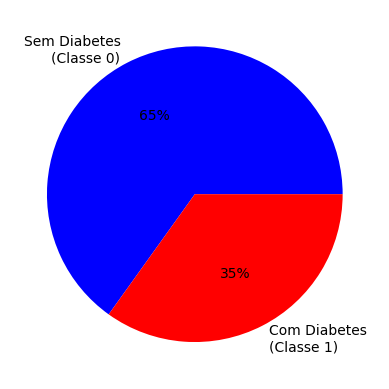

In [6]:
# Dados
classes = ['Sem Diabetes\n(Classe 0)', 'Com Diabetes\n(Classe 1)']
counts = [np.sum(y==0), np.sum(y==1)]
colors = ['blue', 'red']
# Gráfico de pizza
plt.pie(counts, labels=classes, colors=colors, autopct='%1.0f%%')

plt.show()

### 3.1.2 - Conclusões da Análise Inicial

Com base na análise exploratória realizada, podem-se tirar várias conclusões importantes. O dataset apresenta um desequilíbrio entre as classes (500 vs 268 amostras), o que justifica o uso de estratificação na validação cruzada para garantir uma avaliação real do desempenho dos classificadores.

As visualizações realizadas mostram diferenças nas distribuições das features entre as classes, indicando que as features contêm informação discriminativa útil para a classificação. Esta observação é positiva, pois sugere que os atributos potencial para distinguir entre pacientes com e sem diabetes.

Dado o contexto anterior, será necessário investigar o impacto da normalização (*StandardScaler*) no desempenho dos classificadores, especialmente para SVC e Logistic Regression, que são algoritmos sensíveis à escala dos dados. Esta estratégia de pré-processamento poderá melhorar significativamente o desempenho destes modelos.


## 3.2 - Treino de Classificadores

Nesta secção vamos então treinar e avaliar três classificadores binários: `SVC`, `Random Forest Classifier` e `Logistic Regression`. 

Para a divisão dos dados, vamos dividir em 70% para treino e validação e 30% para teste, com estratificação para manter a proporção de classes em ambos os conjuntos. Esta divisão resulta 512 amostras para treino/validação e 256 amostras para teste, garantindo um conjunto de teste suficientemente grande para uma avaliação robusta.

A calibração dos hiperparâmetros de cada modelo será feita utilizando `GridSearchCV` com validação cruzada estratificada (**StratifiedKFold** com 3 _folds_). Esta abordagem permite-nos encontrar o melhor conjunto de hiperparametros.

Adicionalmente, para cada classificador, iremos também encontrar o melhor limiar de decisão utilizando validação cruzada. Em vez de usar o limiar padrão, vamos testar múltiplos limiares (entre 0 e 1) para encontrar aquele que maximiza o F1-Score no conjunto de treino/validação. Esta otimização é realizada usando `cross_val_predict`, que treina modelos em cada _fold_ e prevê nas amostras de validação. O limiar otimizado é então aplicado ao conjunto de teste para avaliação final.

As métricas utilizadas para avaliar o desempenho incluem **Matriz de Confusão**, **Precision**, **Recall**, **F1-Score**, **Curva ROC** e **AUC**, bem como **Curva Precision-Recall**. A avaliação será realizada tanto no conjunto de treino quanto no conjunto de teste para detetar possível overfitting e garantir a capacidade de generalização dos modelos.

In [34]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=1/3,stratify=y)
cv = StratifiedKFold(n_splits=3) # para o grid search mais tarde

### 3.2.1 - SVC (Alice)

#### TODO:
- Criar o classificador e treinar com calibração dos hiper parametros, GridSearchCV (printar a confusion matrix)
- Escolher o limiar



### 3.2.1.1 - Encontrar Hiperparametros

In [108]:
# Definir os hiperparâmetros
# https://stackoverflow.com/questions/72101295/python-gridsearchcv-taking-too-long-to-finish-running

# Final params
#param_grid_svc = {
#    'C': [0.5, 1, 5,  10, 20, 100, 200, 400],
#    'kernel': ['linear', 'rbf', 'sigmoid'],
#    'gamma': ['scale', 'auto', 0.1, 1, 10, 100, 200],
#    'degree': [2, 3, 4, 5]
#}

param_grid_svc = {
    'kernel': ['linear', 'sigmoid'],
}

X_train_scaled = np.ascontiguousarray(X_train_val, dtype=np.float64)

grid_search_svc = GridSearchCV(
    estimator=SVC(probability=True, random_state=42, cache_size=1000), # aumentar o cache size
    param_grid=param_grid_svc,
    cv=cv,
    n_jobs=-1, #-1 é para usar todos os cores em processamento paralelo
)

# Treinar o modelo com GridSearchCV
grid_search_svc.fit(X_train_scaled, y_train_val)  
print(grid_search_svc.best_params_)

# Usar o melhor modelo encontrado
svc_calibrated = grid_search_svc.best_estimator_



{'kernel': 'linear'}



Desempenho no conjunto de Treino
              precision    recall  f1-score   support

           0       0.79      0.90      0.84       333
           1       0.75      0.55      0.63       179

    accuracy                           0.78       512
   macro avg       0.77      0.72      0.74       512
weighted avg       0.77      0.78      0.77       512


Desempenho no conjunto de Teste
              precision    recall  f1-score   support

           0       0.79      0.90      0.84       167
           1       0.75      0.55      0.64        89

    accuracy                           0.78       256
   macro avg       0.77      0.73      0.74       256
weighted avg       0.78      0.78      0.77       256



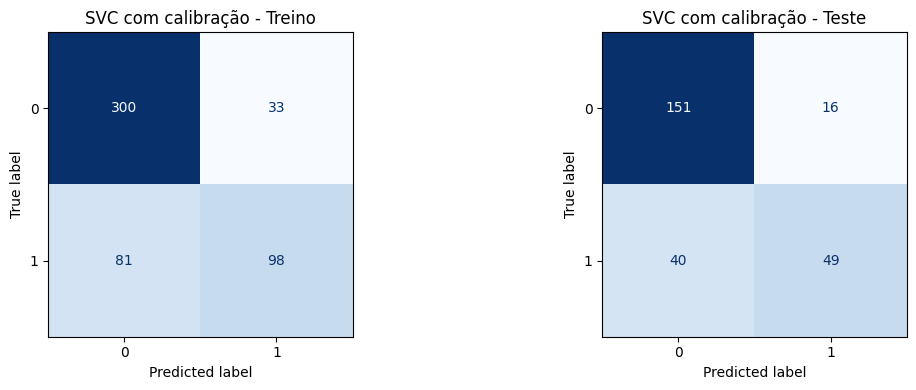

In [109]:
# Previsões no conjunto de treino
y_train_pred_cal = svc_calibrated.predict(X_train_val)
print("\nDesempenho no conjunto de Treino")
print(classification_report(y_train_val, y_train_pred_cal))
cm_train_cal = confusion_matrix(y_train_val, y_train_pred_cal)

# Previsões no conjunto de teste
y_test_pred_cal = svc_calibrated.predict(X_test)
print("\nDesempenho no conjunto de Teste")
print(classification_report(y_test, y_test_pred_cal))
cm_test_cal = confusion_matrix(y_test, y_test_pred_cal)

# Plotar matrizes de confusão usando a função
plot_confusion_matrices(cm_train_cal, cm_test_cal, 'SVC com calibração')

In [ ]:
# Obter probabilidades previstas usando validação cruzada
# cross_val_predict treina modelos em cada fold e prevê no conjunto de validação
y_train_proba_cv = cross_val_predict(
    SVC(probability=True, random_state=42, **grid_search_svc.best_params_),
    X_train_val, 
    y_train_val,
    cv=cv,
    method='predict_proba'
)[:, 1]

# Testar diferentes limiares usando as probabilidades de validação cruzada
threshold_candidates = np.linspace(0, 1, 50)
f1_scores = []

for threshold in threshold_candidates:
    ye_threshold = y_train_proba_cv >= threshold
    f1_scores.append(f1_score(y_train_val, ye_threshold))

# Encontrar o melhor limiar
best_threshold_idx = np.argmax(f1_scores)
best_threshold_f1 = threshold_candidates[best_threshold_idx]
best_cv_f1 = f1_scores[best_threshold_idx]

print(f"Limiar ótimo (validação cruzada): {best_threshold_f1}")
print(f"F1-Score com limiar ótimo: {best_cv_f1}")
print("\nAvaliação no Conjunto de Teste")

# Obter probabilidades no conjunto de teste
y_test_proba = svc_calibrated.predict_proba(X_test)[:, 1]

# Aplicar o limiar otimizado
y_test_pred_threshold = (y_test_proba >= best_threshold_f1).astype(int)

print(f"\nDesempenho com limiar otimizado ({best_threshold_f1}):")
print(classification_report(y_test, y_test_pred_threshold))

# Calcular curvas para visualização
# fp -> false positive
# tp -> true positive
fp, tp, thresholds_roc = roc_curve(y_test, y_test_proba)
roc_auc = auc(fp, tp)

precision_vals, recall_vals, thresholds_pr = precision_recall_curve(y_test, y_test_proba)

# Encontrar o índice do limiar ótimo nas curvas (aproximado)
closest_idx = np.argmin(np.abs(thresholds_pr - best_threshold_f1))

# Matriz de confusão com limiar otimizado
cm_test = confusion_matrix(y_test, y_test_pred_threshold)

# Calcular pontos para os gráficos
fp_threshold = cm_test[0, 1] / cm_test[0, :].sum()  # FP / (TN + FP)
tp_threshold = cm_test[1, 1] / cm_test[1, :].sum()  # TP / (TP + FN)

plot_threshold_analysis(
    fp, tp, roc_auc,
    recall_vals, precision_vals,
    cm_test,
    (fp_threshold, tp_threshold),
    (recall_vals[closest_idx], precision_vals[closest_idx]),
    best_threshold_f1,
    'SVC'
)

### 3.2.2 - Random Forest Classifier (Gui)

#### TODO:
- Criar o classificador e treinar sem calibração (printar a confusion matrix)
- Criar o classificador e treinar com calibração dos hiper parametros, GridSearchCV (printar a confusion matrix)
- Escolher o limiar


### 3.2.3 - Linear Regression (Bruno)

#### TODO:
- Criar o classificador e treinar sem calibração (printar a confusion matrix)
- Criar o classificador e treinar com calibração dos hiper parametros, GridSearchCV (printar a confusion matrix)
- Escolher o limiar


### 3.2.4 - Análise dos classificadores
- Pegar nos dados dos 3 classificadores acima, e juntar num subplot de 3 figuras
    - Printar confusion matrix
    - Printar as curvas roc dos 3 ao mesmo tempo

## 3.3 - Pré-processamento

### 3.3.1 - Standard Scaler

In [9]:
X_norm = StandardScaler().fit_transform(X)

### 3.3.2 - Treino com Pré-Processamento - SVC (Alice)

#### TODO:
- Criar o classificador e treinar sem calibração (printar a confusion matrix)
- Criar o classificador e treinar com calibração dos hiper parametros, GridSearchCV (printar a confusion matrix)
- Escolher o limiar

### 3.3.3 - Treino com Pré-Processamento - Linear Regression (Bruno)

#### TODO:
- Criar o classificador e treinar sem calibração (printar a confusion matrix)
- Criar o classificador e treinar com calibração dos hiper parametros, GridSearchCV (printar a confusion matrix)
- Escolher o limiar

### 3.3.4 - Treino com Pré-Processamento - Random Forest (Gui)

#### TODO:
- Criar o classificador e treinar sem calibração (printar a confusion matrix)
- Criar o classificador e treinar com calibração dos hiper parametros, GridSearchCV (printar a confusion matrix)
- Escolher o limiar

### 3.3.5 - Análise dos classificadores
- Pegar nos dados dos 3 classificadores acima, e juntar num subplot de 3 figuras
    - Printar confusion matrix
    - Printar as curvas roc dos 3 ao mesmo tempo

## 4 - Conclusões


